In [1]:
import mne
import numpy as np
from mne.datasets import eegbci
from mne.channels import make_standard_montage
from scipy.io import loadmat

epochs_each = [0] * 5

for j in range(1,6):
    mat_data = loadmat('D:\BCI_competitionIII\BCI_100Hz\S' + str(j) + '_data_set')

    channels = []
    for i in range(0,118):
        channels.append(mat_data['nfo']['clab'][0][0][0][i][0])

    fs = mat_data['nfo']['fs'][0][0][0][0]
    events_index = mat_data['mrk']['pos'][0][0][0]

    events_labels = mat_data['mrk']['y'][0][0][0]
    events_labels= np.nan_to_num(events_labels, nan=0.0)

    info = mne.create_info(
        ch_names= channels,
        ch_types= ['eeg']*len(channels),
        sfreq= fs
    )

    info.set_montage('standard_1005', on_missing= 'ignore')
    ev = [i*fs*5 for i in range(len(events_labels))]
    events = np.column_stack((np.array(ev, dtype = int),
                            np.zeros(len(events_labels), dtype = int),
                            np.array(events_labels, dtype = int)))

    cnt = mat_data['cnt'] *0.1
    cnt = cnt.T

    data = []
    for i in range(0,len(events_labels)):
            data.append(cnt[:,events_index[i]:events_index[i] + (fs*5)])

    data = np.asanyarray(data)

    t_min = 0.0
    # t_max = 3.5
    event_id = dict(Right= 1, Foot= 2, no=0)
    epochs_each[j-1] = mne.EpochsArray(data, info, events,t_min, event_id, baseline=None)
    # epochs_each[j-1] = epochs_each[j-1].copy().crop(tmin=0.0, tmax=3.5)
    epochs_each[j-1] = epochs_each[j-1].pick_channels(['C3','Cz','C4'])

Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated


In [2]:
del cnt
del data
del mat_data

In [3]:
epochs = mne.concatenate_epochs([epochs_each[0], epochs_each[1], epochs_each[2], epochs_each[3], epochs_each[4]])
# epochs = epochs_each[0]

Not setting metadata
1400 matching events found
No baseline correction applied


In [4]:
epochs

Number of events,1400
Events,Foot: 278Right: 282no: 840
Time range,0.000 – 4.990 sec
Baseline,off


# MRCP & LF-ASD

In [10]:
import sys
import matplotlib.pyplot as plt
eeg1 = epochs.copy().filter(l_freq=0.05, h_freq=3.0, method = 'iir', iir_params= {"order": 12, "ftype":'butter'})
eeg1 = eeg1.copy().set_eeg_reference(ref_channels="average")
# eeg1 = eeg1.copy().crop(tmin=0.0, tmax=3.5)

Setting up band-pass filter from 0.05 - 3 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 48 (effective, after forward-backward)
- Cutoffs at 0.05, 3.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


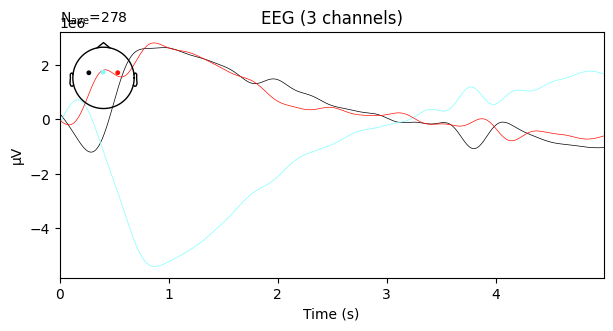

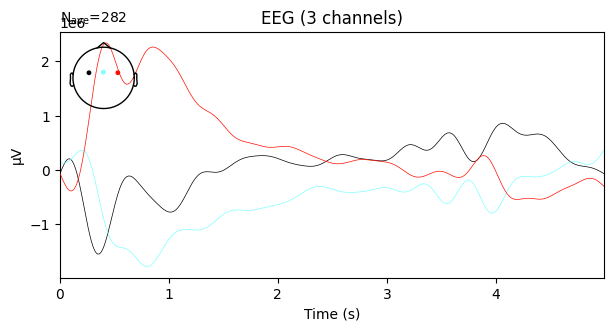

...


In [11]:
eeg1['Foot'].average().plot()
eeg1['Right'].average().plot()
print("...")

Need more than one channel to make topography for eeg. Disabling interactivity.


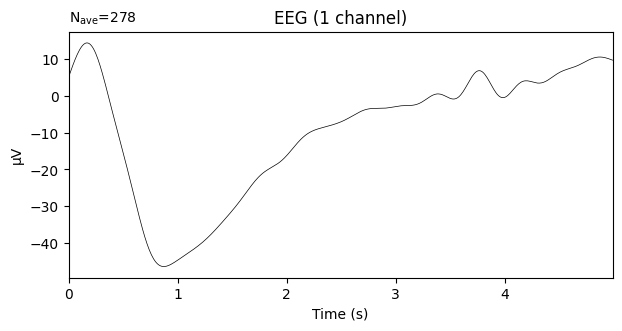

Need more than one channel to make topography for eeg. Disabling interactivity.


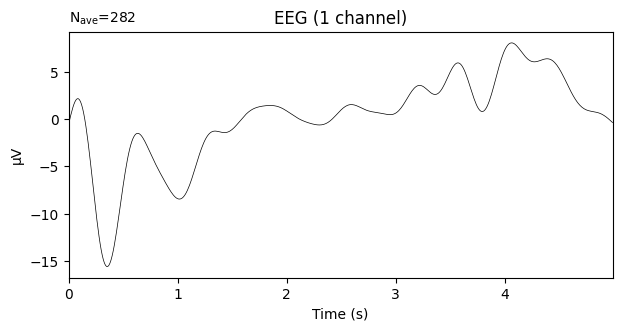

...


In [7]:
eeg1['Foot'].average().plot(scalings=10, picks="Cz")
eeg1['Right'].average().plot(scalings=10, picks="C3")
print('...')

# ERSD

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import seaborn as sns
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
eeg2 = epochs.copy().filter(l_freq=8.0, h_freq=30.0, method = 'iir')
# eeg2 = eeg2.copy().set_eeg_reference(ref_channels="average")
# eeg2 = eeg2.copy().crop(tmin=0.0, tmax=3.5)

Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB



In [9]:
freqs = np.arange(8, 31)  # frequencies from 8-30Hz
vmin, vmax = -1, 0.5  # set min and max ERDS values in plot
baseline = (0, 2)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: percent)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.7s finished


Using a threshold of 1.650294
stat_fun(H1): min=-20.082821 max=6.766377
Running initial clustering …
Found 6 clusters


C:\Users\pipo_\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Permuting : 99/99 [00:01<00:00,   98.40it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  105.10it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.650294


stat_fun(H1): min=-20.082821 max=6.766377
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  102.03it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  101.36it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations


No baseline correction applied
Using a threshold of 1.650294
stat_fun(H1): min=-21.227992 max=5.958977
Running initial clustering …
Found 7 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  101.81it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  104.37it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.650294
stat_fun(H1): min=-21.227992 max=5.958977
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  101.08it/s]


Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


100%|██████████| Permuting : 99/99 [00:00<00:00,  101.44it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations


No baseline correction applied
Using a threshold of 1.650294
stat_fun(H1): min=-20.798610 max=6.366966
Running initial clustering …
Found 5 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  100.60it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  100.62it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.650294


stat_fun(H1): min=-20.798610 max=6.366966
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,   99.28it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  102.97it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations


No baseline correction applied


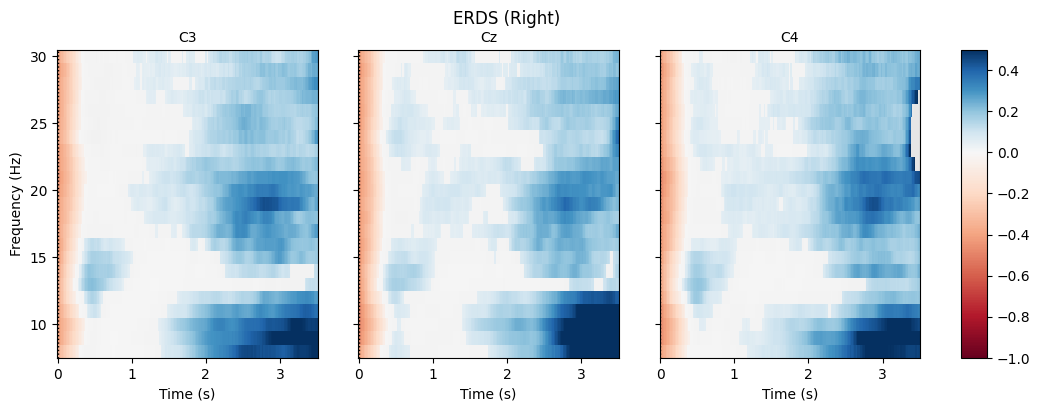

Using a threshold of 1.650373
stat_fun(H1): min=-29.574996 max=8.542255
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  102.80it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  107.03it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.650373
stat_fun(H1): min=-29.574996 max=8.542255
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  100.95it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  106.79it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations


No baseline correction applied
Using a threshold of 1.650373
stat_fun(H1): min=-24.399718 max=6.954909
Running initial clustering …
Found 6 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  101.90it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,   99.13it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations


Using a threshold of -1.650373
stat_fun(H1): min=-24.399718 max=6.954909
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   97.16it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  101.79it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations


No baseline correction applied
Using a threshold of 1.650373
stat_fun(H1): min=-29.731323 max=8.016029
Running initial clustering …
Found 5 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   98.60it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  106.40it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.650373
stat_fun(H1): min=-29.731323 max=8.016029
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 99/99 [00:00<00:00,  104.01it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  107.28it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied


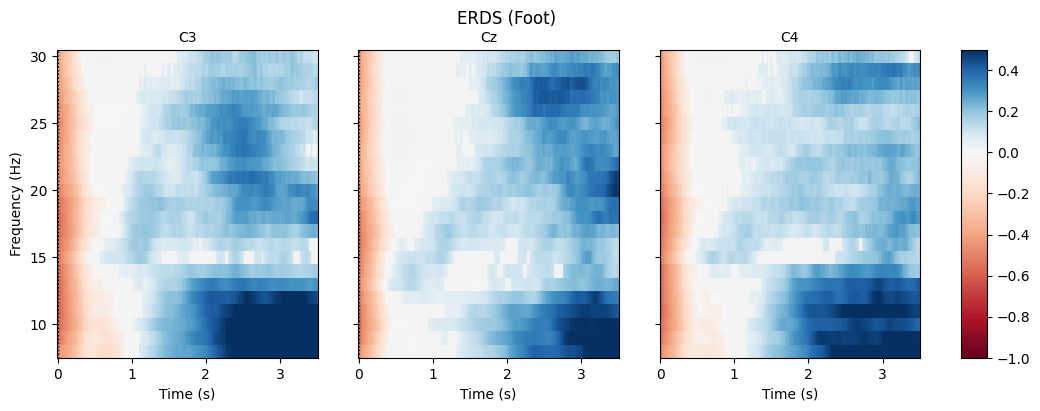

In [10]:
tfr = tfr_multitaper(
    eeg2,
    freqs=freqs,
    n_cycles=freqs,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=2,
)
tfr.crop(0, 3.5).apply_baseline(baseline, mode="percent")
event_id2 = dict(Right = 1, Foot = 2)

for event in event_id2:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
    )
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",
            cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            mask=mask,
            mask_style="mask",
        )

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


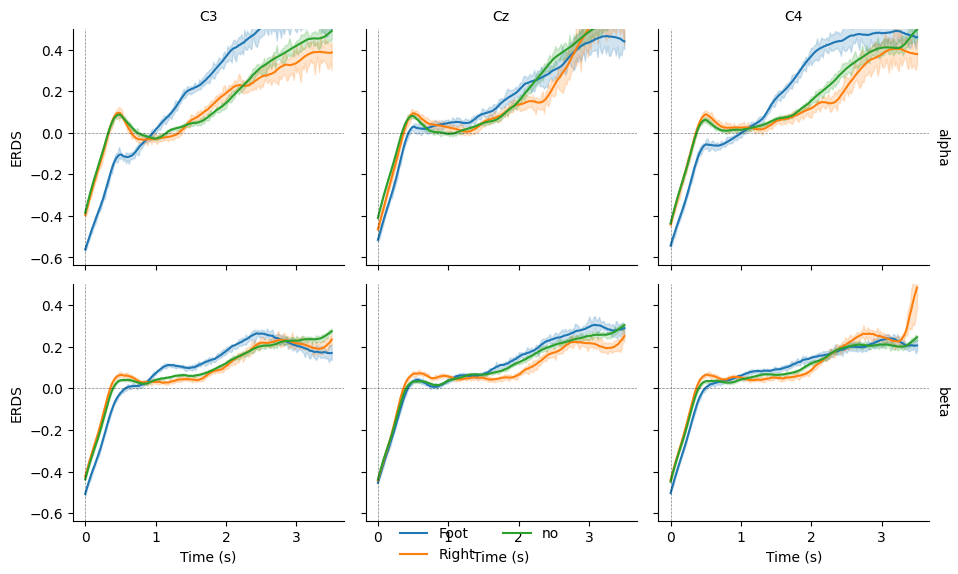

In [11]:
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "delta": 3, "theta": 7, "alpha": 13, "beta": 35, "gamma": 140}
df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["delta", "theta", "alpha", "beta"]
df = df[df.band.isin(freq_bands_of_interest)]
df["band"] = df["band"].cat.remove_unused_categories()

# Order channels for plotting:
df["channel"] = df["channel"].cat.reorder_categories(("C3", "Cz", "C4"), ordered=True)

g = sns.FacetGrid(df, row="band", col="channel", margin_titles=True)
g.map(sns.lineplot, "time", "value", "condition", n_boot=10)
axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, vmax))
g.set_axis_labels("Time (s)", "ERDS")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc="lower center")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)
plt.show()

# CSP

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit,StratifiedKFold ,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from mne import Epochs, pick_types, events_from_annotations, create_info
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import AverageTFR

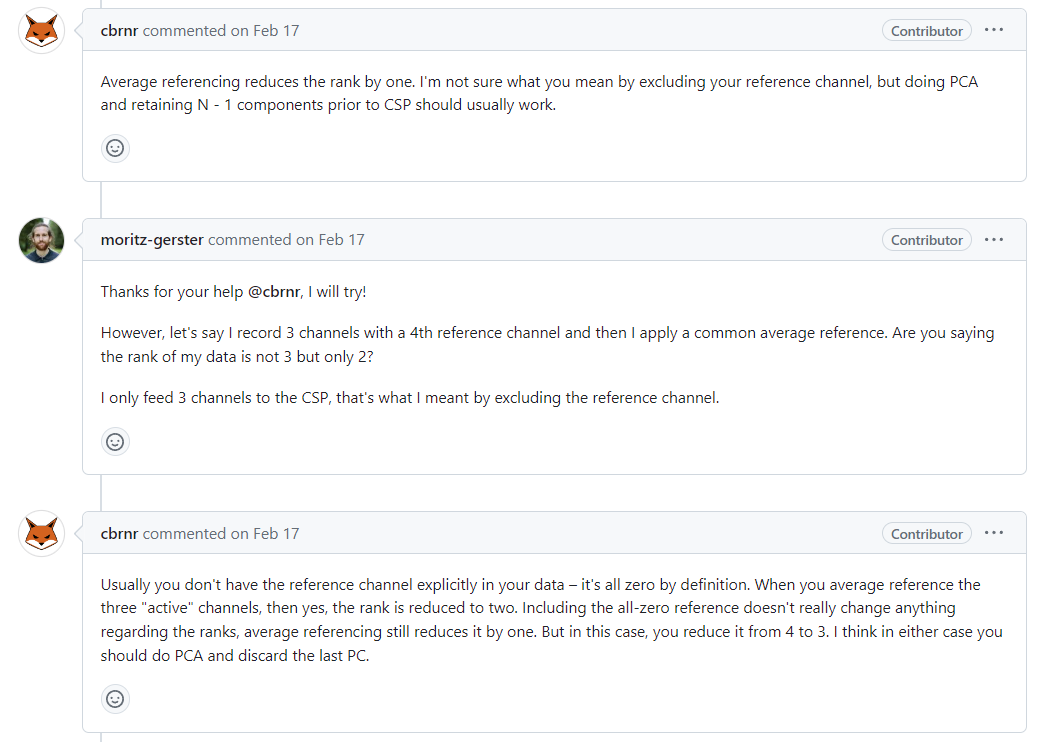

In [13]:
from IPython.display import Image
Image('csp_problem.png')

In [27]:
CSP_epochs = epochs.copy().filter(l_freq=13, h_freq=26.0, method = 'iir', iir_params= {"order": 12, "ftype":'butter'})
# CSP_epochs = CSP_epochs.copy().set_eeg_reference(ref_channels="average")
CSP_train = CSP_epochs['Right','Foot'].crop(tmin=0.0, tmax=3.5)
labels = CSP_train.events[:, -1]

Setting up band-pass filter from 13 - 26 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 48 (effective, after forward-backward)
- Cutoffs at 13.00, 26.00 Hz: -6.02, -6.02 dB



Computing rank from data with rank=None
    Using tolerance 1.1 (2.2e-16 eps * 3 dim * 1.6e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None


    Using tolerance 1.1 (2.2e-16 eps * 3 dim * 1.7e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1 (2.2e-16 eps * 3 dim * 1.6e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1 (2.2e-16 eps * 3 dim * 1.7e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1 (2.2e-16 eps * 3 dim * 1.6e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels w

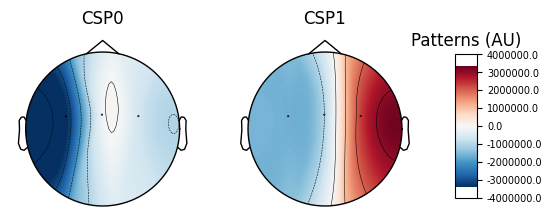

Classification accuracy: 0.721429 / Chance level: 0.503571
[[190  92]
 [ 75 203]]


In [28]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
CSP_epochs_data = CSP_epochs['Right','Foot'].get_data()
CSP_epochs_data_train = CSP_train.get_data()
cv = ShuffleSplit(5, test_size=0.2, random_state=42)
cv_split = cv.split(CSP_epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=2, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, CSP_epochs_data_train, labels, cv=cv, n_jobs=None)
CSP_predicted = cross_val_predict(clf, CSP_epochs_data_train, labels, cv=5)
# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)

# plot CSP patterns estimated on full data for visualization
CSP_coff = csp.fit_transform(CSP_epochs_data, labels)

csp.plot_patterns(CSP_epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance)
)

conf_matrix = confusion_matrix(labels, CSP_predicted)
print(conf_matrix)


In [16]:
np.shape(CSP_train['Right','Foot'].get_data())

(560, 3, 351)

In [29]:
shape = np.shape(CSP_train['Right','Foot'].get_data())
array_2d = CSP_train.pick(["C3","Cz","C4"]).get_data().reshape(shape[0], shape[1]*shape[2])

scores = cross_val_score(lda, array_2d, labels, cv=cv, n_jobs=None)
CSP_predicted = cross_val_predict(lda, array_2d, labels, cv=5)

conf_matrix = confusion_matrix(labels, CSP_predicted)
print("LDA only classification scores", np.mean(scores))
print(conf_matrix)

LDA only classification scores 0.4892857142857142
[[142 140]
 [154 124]]


Computing rank from data with rank=None
    Using tolerance 1.6 (2.2e-16 eps * 3 dim * 2.3e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None


    Using tolerance 1.6 (2.2e-16 eps * 3 dim * 2.4e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6 (2.2e-16 eps * 3 dim * 2.4e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6 (2.2e-16 eps * 3 dim * 2.4e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6 (2.2e-16 eps * 3 dim * 2.4e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels w

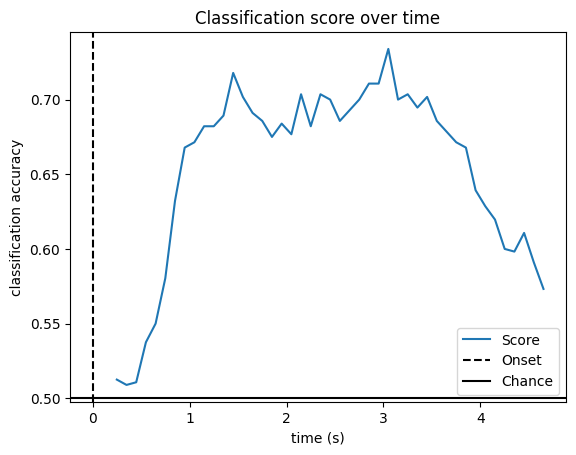

In [18]:
sfreq = CSP_epochs['Right','Foot'].info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, CSP_epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(CSP_epochs_data_train[train_idx], y_train)
    X_test = csp.transform(CSP_epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(CSP_epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + CSP_epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()


Setting up band-pass filter from 0.1 - 3.4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 3.42 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.42 Hz)
- Filter length: 3301 samples (33.010 sec)



C:\Users\pipo_\AppData\Local\Temp\ipykernel_8372\549955199.py:29: RuntimeWarning: filter_length (3301) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  CSP_filter = epochs.copy().filter(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 5.6 (2.2e-16 eps * 3 dim * 8.4e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.9 (2.2e-16 eps * 3 dim * 8.9e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.6 (2.2e-16 eps * 3 dim * 8.4e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.9 (2.2e-16 eps * 3 dim * 8.8e+15  max singular value)
    Estimated rank (mag): 3
    MAG

[Parallel(n_jobs=1)]: Done 4200 out of 4200 | elapsed:    0.7s finished


    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.6 (2.2e-16 eps * 3 dim * 8.4e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6 (2.2e-16 eps * 3 dim * 9e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.6 (2.2e-16 eps * 3 dim * 8.4e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPI

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 3 dim * 2.8e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 3 dim * 2.7e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9 (2.2e-16 eps * 3 dim * 2.8e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7 (2.2e-16 eps * 3 dim * 2.6e+15  max singular value)
    Estimated rank (mag): 3
    MAG

[Parallel(n_jobs=1)]: Done 4200 out of 4200 | elapsed:    0.4s finished


    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 3 dim * 2.8e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 3 dim * 2.7e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.9 (2.2e-16 eps * 3 dim * 2.8e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 2.1 (2.2e-16 eps * 3 dim * 3.1e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1 (2.2e-16 eps * 3 dim * 3.1e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1 (2.2e-16 eps * 3 dim * 3.2e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2 (2.2e-16 eps * 3 dim * 3.1e+15  max singular value)
    Estimated rank (mag): 3
    MAG: 

[Parallel(n_jobs=1)]: Done 4200 out of 4200 | elapsed:    0.4s finished


    Using tolerance 2.1 (2.2e-16 eps * 3 dim * 3.2e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1 (2.2e-16 eps * 3 dim * 3.1e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2 (2.2e-16 eps * 3 dim * 3e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1 (2.2e-16 eps * 3 dim * 3.2e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 3 dim * 2.6e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7 (2.2e-16 eps * 3 dim * 2.6e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 3 dim * 2.7e+15  max singular value)


[Parallel(n_jobs=1)]: Done 4200 out of 4200 | elapsed:    0.4s finished


    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7 (2.2e-16 eps * 3 dim * 2.6e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 3 dim * 2.7e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.8 (2.2e-16 eps * 3 dim * 2.7e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 1.1 (2.2e-16 eps * 3 dim * 1.7e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2 (2.2e-16 eps * 3 dim * 1.7e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1 (2.2e-16 eps * 3 dim * 1.7e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2 (2.2e-16 eps * 3 dim * 1.7e+15  max singular value)
    Estimated rank (mag): 3
    MAG

[Parallel(n_jobs=1)]: Done 4200 out of 4200 | elapsed:    0.5s finished


    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1 (2.2e-16 eps * 3 dim * 1.7e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2 (2.2e-16 eps * 3 dim * 1.7e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1 (2.2e-16 eps * 3 dim * 1.7e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 0.97 (2.2e-16 eps * 3 dim * 1.5e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1 (2.2e-16 eps * 3 dim * 1.5e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.97 (2.2e-16 eps * 3 dim * 1.5e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1 (2.2e-16 eps * 3 dim * 1.5e+15  max singular value)
    Estimated rank (mag): 3
    MAG: 

[Parallel(n_jobs=1)]: Done 4200 out of 4200 | elapsed:    0.7s finished


    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.98 (2.2e-16 eps * 3 dim * 1.5e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1 (2.2e-16 eps * 3 dim * 1.5e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.98 (2.2e-16 eps * 3 dim * 1.5e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 0.91 (2.2e-16 eps * 3 dim * 1.4e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.94 (2.2e-16 eps * 3 dim * 1.4e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.9 (2.2e-16 eps * 3 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.93 (2.2e-16 eps * 3 dim * 1.4e+15  max singular value)
    Estimated rank (mag): 3
    

[Parallel(n_jobs=1)]: Done 4200 out of 4200 | elapsed:    0.6s finished


    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.92 (2.2e-16 eps * 3 dim * 1.4e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.94 (2.2e-16 eps * 3 dim * 1.4e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.92 (2.2e-16 eps * 3 dim * 1.4e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance usi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 0.84 (2.2e-16 eps * 3 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.85 (2.2e-16 eps * 3 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.83 (2.2e-16 eps * 3 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.84 (2.2e-16 eps * 3 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 3
   

[Parallel(n_jobs=1)]: Done 4200 out of 4200 | elapsed:    1.2s finished


    Using tolerance 0.85 (2.2e-16 eps * 3 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.85 (2.2e-16 eps * 3 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.85 (2.2e-16 eps * 3 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.84 (2.2e-16 eps * 3 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channe

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None
    Using tolerance 0.78 (2.2e-16 eps * 3 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.77 (2.2e-16 eps * 3 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.77 (2.2e-16 eps * 3 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.77 (2.2e-16 eps * 3 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 3
   

[Parallel(n_jobs=1)]: Done 4200 out of 4200 | elapsed:    0.5s finished


Done.
Computing rank from data with rank=None
    Using tolerance 0.78 (2.2e-16 eps * 3 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.79 (2.2e-16 eps * 3 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.78 (2.2e-16 eps * 3 dim * 1.2e+15  max singular value)
    Estimated rank (mag): 3
    MAG: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.78 (2.2e-16 eps * 3 dim * 1.2e+15  max singular value)
    Estimated rank (mag):

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


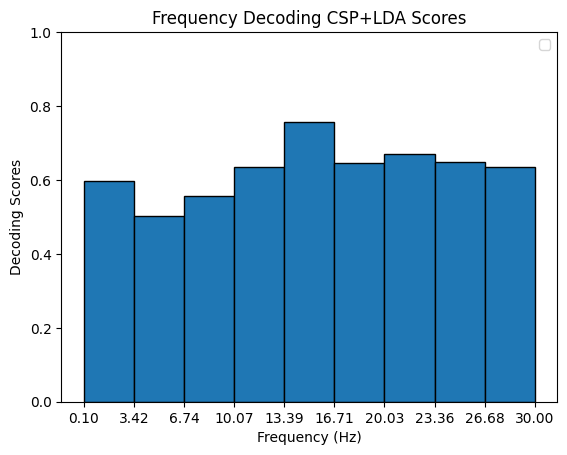

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


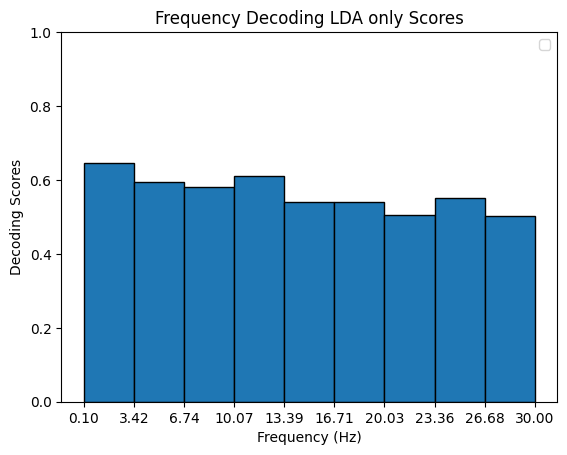

In [19]:
# Classification & time-frequency parameters
tmin, tmax = 0.000, 3.500
n_cycles = 10.0  # how many complete cycles: used to define window size
min_freq = 0.1
max_freq = 30.0
n_freqs = 10 # how many frequency bins to use

# Assemble list of frequency range tuples
freqs = np.linspace(min_freq, max_freq, n_freqs)  # assemble frequencies
freq_ranges = list(zip(freqs[:-1], freqs[1:]))  # make freqs list of tuples

# Infer window spacing from the max freq and number of cycles to avoid gaps
window_spacing = n_cycles / np.max(freqs) / 2.0
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(centered_w_times)

# Instantiate label encoder
le = LabelEncoder()

freq_scores_CSP = np.zeros((n_freqs - 1,))
freq_scores_LDA = np.zeros((n_freqs - 1,))

# Loop through each frequency range of interest
for freq, (fmin, fmax) in enumerate(freq_ranges):
    # Infer window size based on the frequency being used
    w_size = n_cycles / ((fmax + fmin) / 2.0)  # in seconds

    # Apply band-pass filter to isolate the specified frequencies
    CSP_filter = epochs.copy().filter(
        fmin, fmax, fir_design="firwin", skip_by_annotation="edge"
    )

    y = le.fit_transform(CSP_filter['Right','Foot'].events[:, -1])

    X = CSP_filter['Right','Foot'].get_data()

    # Save mean scores over folds for each frequency and time window
    freq_scores_CSP[freq] = np.mean(
        cross_val_score(estimator=clf, X=X, y=y, cv=cv), axis=0
    )

    shape = np.shape(CSP_filter['Right','Foot'].get_data())
    X = CSP_filter['Right','Foot'].get_data().reshape(shape[0], shape[1]*shape[2])

    freq_scores_LDA[freq] = np.mean(
        cross_val_score(estimator=lda, X=X, y=y, cv=cv), axis=0
    )
plt.bar(
freqs[:-1], freq_scores_CSP, width=np.diff(freqs)[0], align="edge", edgecolor="black"
)
plt.xticks(freqs)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Decoding Scores")
plt.title("Frequency Decoding CSP+LDA Scores")
plt.show()

plt.bar(
freqs[:-1], freq_scores_LDA, width=np.diff(freqs)[0], align="edge", edgecolor="black"
)
plt.xticks(freqs)
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Decoding Scores")
plt.title("Frequency Decoding LDA only Scores")
plt.show()

# PSD and Power Plot

In [20]:
eeg4 = epochs.copy().filter(l_freq=1.0, h_freq=35.0, method = 'iir', iir_params= {"order": 12, "ftype":'butter'})
eeg4 = eeg4.copy().set_eeg_reference(ref_channels="average")
epochs_name = ['Right', 'Foot']
picks = ("C3", "Cz", "C4")
PSD_epochs = eeg4['Right', 'Foot']

Setting up band-pass filter from 1 - 35 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 48 (effective, after forward-backward)
- Cutoffs at 1.00, 35.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


    Using multitaper spectrum estimation with 7 DPSS windows


Averaging across epochs...
...


c:\Python311\Lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


No baseline correction applied


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


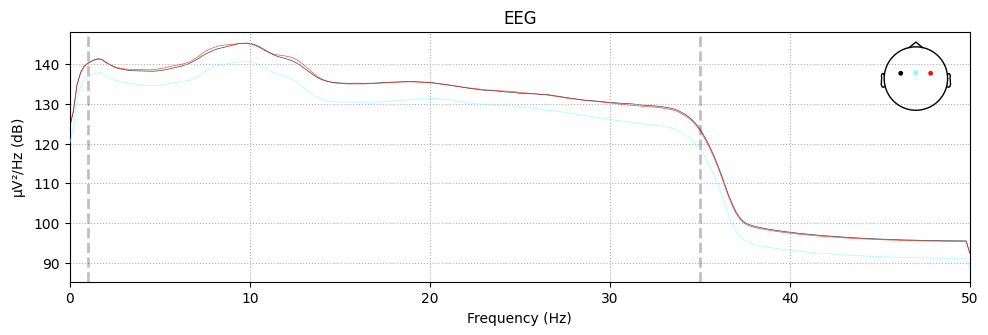

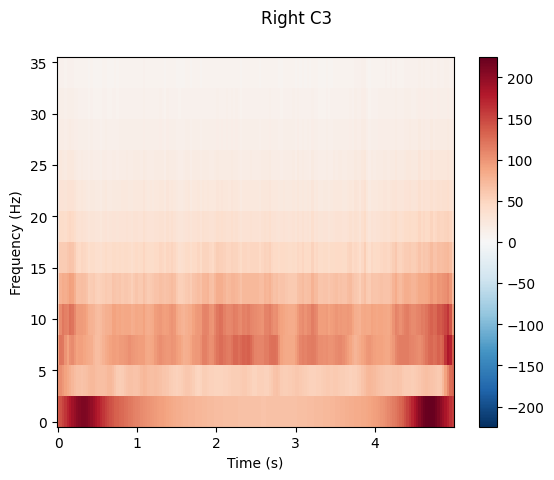

No baseline correction applied


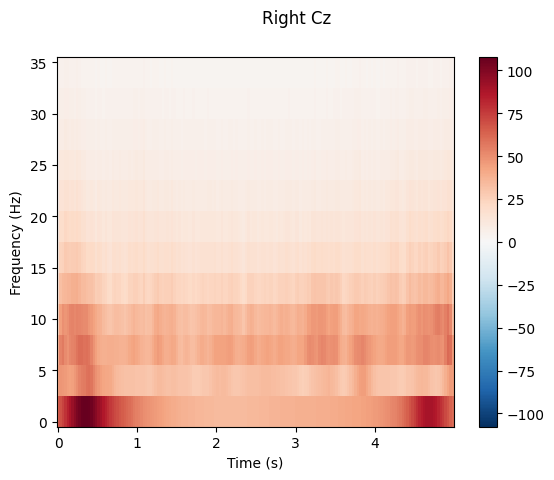

No baseline correction applied


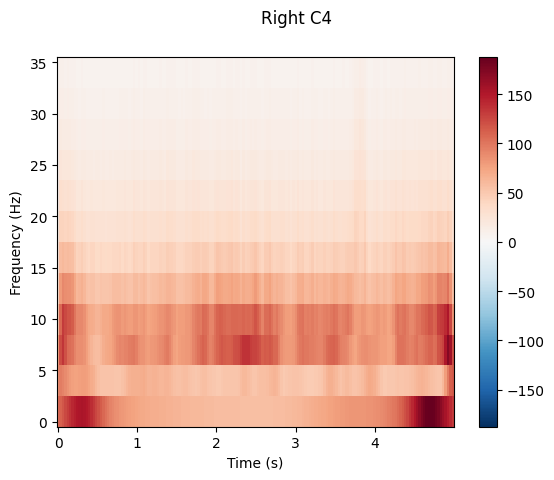

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


No baseline correction applied


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


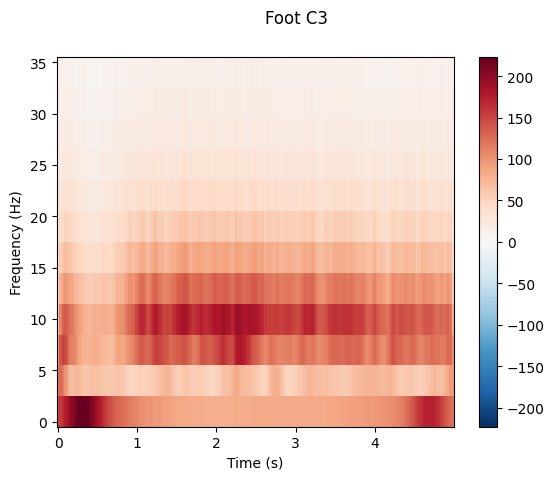

No baseline correction applied


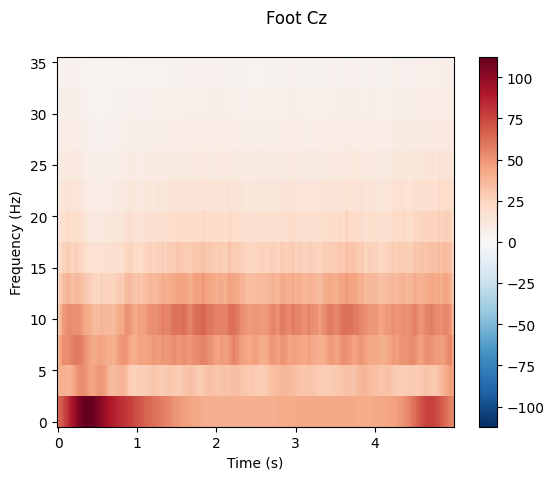

No baseline correction applied


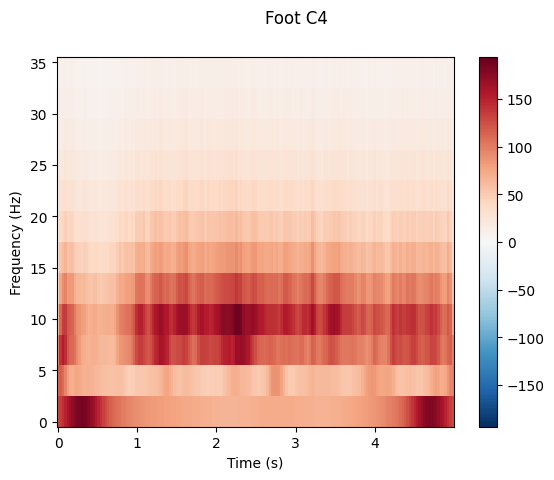

In [21]:
eeg4.compute_psd(fmax=50).plot(picks="data", exclude="bads")
print("...")
frequencies = np.arange(1, 35, 3)
for i in range(0,2):
    power = mne.time_frequency.tfr_morlet(
        PSD_epochs[epochs_name[i]], n_cycles=2, return_itc=False, freqs=frequencies, decim=3)
    for j in range(0,3):
        power.plot(picks = picks[j], title = str(epochs_name[i]) + " " + str(picks[j]))